In [34]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import country_converter as coco
import random
import html5lib
import os
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

## Introduction

The project aims to determine factors attributable to the prevalence of depression among women and use statistical learning models to make a prediction on the prevalence of depression. 

The report will cover the issue background, information about data used in the analyses, methods in the analyses, analysis results, and the next step for future analysis.

## Problem Statement 

This project intends to determine whether depression is indeed more prevalent in women than in men, and if so, what factors affect women's mental health. This is a regression problem that takes variables to make a prediction on the prevalence of depression among women. 

## Background 

Mental health disorders are more prevalent than one would expect. Researchers from Our World in Data in 2017 estimated that more than 10% of people globally lived with some sort of mental health disorders, and the existing statistics related to mental health are underreported and poorly understood (Ritchie and Roser, 2018). And according to the World Health Organization, depression is one of the leading causes of disability, and suicide is the second leading cause of death among young people.

Moreover, some studies show that most mental health disorders, such as depression, anxiety, bipolar and eating disorders, are more common in women than in men around the world (Ritchier, 2018). Mayo Clinic listed factors that would be associated with the risk of mental health disorders, especially with the risk of depression. According to Mayo Clinic, hormonal changes along with biological factors and cultural factors would contribute to depression in women. Specially, for example, Mayo Clinic states that "women are much more likely than men to live in poverty, causing concerns such as uncertainty about the future and decreased access to community and health care resources", and "women are more likely than men to experience sexual abuse." (Mayo Clinic, 2019) Instead of determining the mental health issue in general, this project will specifically focus on one type of mental health disorders: depression. 

## Data

Most indicators are reported by the World Bank. However, as the focus on this project is social and political factors, I only downloaded relevant data, such as regime score, domestic violence, human rights score, etc from Our World in Data. In addition to the downloadable data, I also scraped the table indicating the share of women in national parliaments in the most recent election from Inter-Parliamentary Union. 

The unit of analysis is country-year. The dataset will cover UN member states from 2010 to 2017. 

The outcome that would be analyzed and predicted is the prevalence of depression among women, since the focus is depression instead of all types of mental health disorders summed together. The data are measured as a percentage on 0-to-100 scale. 

Independent variables include population density (measured by people per sq. km of land area), GDP per capita, human rights score (measured by how much the government protects and respects human rights, on -10-to-10 scale), regime type index(on a scale from -10 – full autocracy, to 10 – full democracy), deaths from terrorist attacks, the rate of violence by intimate partner, whether the country has a law prohibiting or invalidating child marriage, the share of women in parliaments (measured as a percentage on 0-100 scale), women’s economic rights (an ordinal variable ranging from 0 to 3) and the average births given per women. While I intended to include human resources data in the mental health sectors, not every country reports them: for instance, the U.K and South Korea never reported it to the WHO, and Russia reported only some of the indicators. It is not reasonable to drop observations due to such missingness when other factors are complete, so I decided not to include the human resources data. 

For these variables included in this project, there are still issues that need to be addressed. First, there contains missing data. To address this issue, if there are missing data in the dependent variable: the prevalence of depression, then these observations are not included; if the missingness exists in independent variables, then it is replaced with a value depending on the specific context. The detail will be addressed in steps of data wrangling. 

For data wrangling, I first restricted the observations to only UN member states and from 2010 to 2017, because several countries’ data were missing after the year of 2017. Then I combined datasets together with the merge function by country and year. As briefly mentioned earlier, I dropped observations that had missingness in the prevalence of depression in women, as it is the outcome that would be analyzed and predicted. For the regime type score, and women’s economic rights, I filled the missing data with the country’s average. For the deaths from terrorist attacks, since a terrorist attack is not a frequent event for many countries, I filled the missing data with 0. For the variable indicating whether there is a law prohibiting child marriage, the dataset did not cover every year, so in any of the reported years there was a value, then I replaced with 1 and otherwise with 0. Lastly, there is an exception when it comes to how I dealt with missing data: the share of women in parliaments. Since the election does not occur at the same frequency across the world, I used the most recent value that I scraped for all the observations. After the filling process, there were still missing values that were very difficult to address given my available information; thus, I dropped these observations, and dropped duplicate values that might have come at merges. I also created a variable which is the absolute difference between the prevalence of depression in women and the prevalence in men to observe the patterns. 

In [2]:
dat = []
#Get UN member states
un_page = requests.get("https://www.un.org/en/member-states/")
soup = BeautifulSoup(un_page.content, 'html.parser')
se = "#block-system-main > div > div > div"
#store the country names into a list
countries = [i.get_text() for i in soup.select(se)]
n = []
for i in countries:
    n.append(i.split('    ')[1])

#get rid of all dates
m = []
for i in n:
    m.append(i.split('  ')[1])
m #now we have all countries in the list
m = coco.convert(m, to = 'name_short') #convert to standard names
UN = pd.DataFrame(m, columns = ['Country'])

In [3]:
#outcome
depression = pd.read_csv('Data\\prevalence-of-depression.csv')
depression = depression.query("Year >= 2010 and Year <= 2017")
depression = depression[["Entity", "Year",
            "Prevalence - Depressive disorders - Sex: Male - Age: Age-standardized (Percent)",
           "Prevalence - Depressive disorders - Sex: Female - Age: Age-standardized (Percent)"]]
depression.columns = ['Country','Year','Depression_M', "Depression_F"]
depression.Country = coco.convert(list(depression.Country), to = 'name_short')
depression.Country = depression.Country.astype("string")
depression

dat = UN.merge(depression, how = 'left', on = 'Country')

Abkhazia not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Africa not found in regex
Akrotiri and Dhekelia not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Andean Latin America not found in regex
Asia not found in regex
Asia not found in regex
Asia not found in regex
Asia not found in regex
Asia not found in regex
Asia not found in regex
Asia not found in regex
Asia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in regex
Australasia not found in 

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

Europe not found in regex
Europe not found in regex
Europe not found in regex
Europe not found in regex
Europe not found in regex
Europe not found in regex
Europe not found in regex
Europe not found in regex
Hanover not found in regex
Hesse Electoral not found in regex
Hesse Grand Ducal not found in regex
High SDI not found in regex
High SDI not found in regex
High SDI not found in regex
High SDI not found in regex
High SDI not found in regex
High SDI not found in regex
High SDI not found in regex
High SDI not found in regex
High-income not found in regex
High-income not found in regex
High-income not found in regex
High-income not found in regex
High-income not found in regex
High-income not found in regex
High-income not found in regex
High-income not found in regex
High-income Asia Pacific not found in regex
High-income Asia Pacific not found in regex
High-income Asia Pacific not found in regex
High-income Asia Pacific not found in regex
High-income Asia Pacific not found in regex
H

In [4]:
#GDP
GDP = pd.read_csv('Data\\gdp-per-capita-worldbank.csv')
GDP.columns = ['Country','Code','Year','GDPpc']
GDP = GDP.query("Year > 2009")
GDP.Country = coco.convert(list(GDP.Country), to = 'name_short')

dat = dat.merge(GDP, how = 'left', on = ['Country','Year']).drop('Code', axis = 1)

#population density 
density = pd.read_csv("Data\\population-density.csv")
density.columns = ['Country','Code','Year','Pop_density']
density = density.query("Year > 2009")
density.Country = coco.convert(list(density.Country), to = 'name_short')

dat = dat.merge(density, how = 'left', on = ['Country', 'Year']).drop('Code', axis = 1)

#avg births/women
fertility = pd.read_csv("Data\\fertility.csv")
fertility = fertility[['Entity','Year','Fertility rate, total (births per woman)']]
fertility.columns = ['Country','Year','Fertility']
fertility.Country = coco.convert(list(fertility.Country), to = 'name_short')
fertility.Country = fertility.Country.astype("string")

dat = dat.merge(fertility, how = 'left', on = ['Country', 'Year'])


#human rights score 
score = pd.read_csv("Data\\human-rights-scores.csv")
score.columns = ['Country','Code','Year','human_rights_score']
score = score.query("Year > 2009")
score.Country = coco.convert(list(score.Country), to = 'name_short')

dat = dat.merge(score, 'left', ['Country', 'Year']).drop('Code',axis = 1)

#regime type as a score
regime = pd.read_csv("Data\\political-regime-updated2016.csv")
regime.columns = ['Country','Code','Year','Regime_score']
regime = regime.query("Year > 2009")
regime.Country = coco.convert(list(regime.Country), to = 'name_short')

dat = dat.merge(regime, 'left', ['Country','Year']).drop('Code', axis = 1)
#mind those missing data


#deaths from terroist attacks 
trsm = pd.read_csv("Data\\deaths-from-terrorist-attacks.csv")
trsm.columns = ['Country','Code','Year','Trsm_Fatalities']
trsm.Country = coco.convert(list(trsm.Country), to = 'name_short')
dat = dat.merge(trsm.query('Year > 2009'), 'left', ['Country', 'Year']).drop('Code', axis = 1)


#domestic violence
dom_V = pd.read_csv("Data\\violence_by_intimate_partner.csv")
dom_V.columns = ['Country','Code','Year','Dom_violence']
dom_V.Country = coco.convert(list(dom_V.Country), to = 'name_short')

dat = dat.merge(dom_V.query('Year > 2009'), 'left', ['Country', 'Year']).drop('Code', axis = 1)

#law about child marriage
child_m_law = pd.read_csv("Data\\does-law-prohibit-or-invalidate-child-or-early-marriage.csv")
child_m_law.columns = ['Country','Code','Year','child_marriage_law']
child_m_law.Country = coco.convert(list(child_m_law.Country), to = 'name_short')

dat = dat.merge(child_m_law.query('Year > 2009'), 'left', ['Country','Year']).drop('Code', axis = 1)

#women in parliaments 
url = "http://archive.ipu.org/wmn-e/classif.htm"
raw = requests.get(url)
#Read the content
tables = pd.read_html(raw.text)
parliaments = tables[3]

parliaments.columns = ['Rank','Country','Election_lower','seats_lower',
                    'women_seats_lower','women_seats%_lower','Election_upper',
                    'seats_upper','women_seats_upper','women_seats%_upper']

parliaments.Country = coco.convert(list(parliaments.Country), to = 'name_short')
parliaments = parliaments[parliaments['Country'] != 'not found']
#many upper election data are unavailable
#we want to keep only available data
#also election happens regularly and it varies by country
#we'll use the same data for those years
dat = dat.merge(parliaments[['Country','women_seats%_lower','women_seats%_upper']], 'left','Country')

#economic rights 
econ = pd.read_csv("Data\\womens-economic-rights.csv")
econ.columns = ['Country','Code','Year','women_econ_rights']
econ.Country = coco.convert(list(econ.Country), to = 'name_short')
#data only available before 2011
econ.groupby('Country').mean().filter(['Country','women_econ_rights'])
dat = dat.merge(econ.groupby('Country').mean().filter(['Country','women_econ_rights']), 'left','Country')

Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Arab World not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Central Europe and the Baltics not found in regex
Early-demographic divide

Least developed countries: UN classification not found in regex
Least developed countries: UN classification not found in regex
Least developed countries: UN classification not found in regex
Least developed countries: UN classification not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low income not found in regex
Low income not found in regex
Low income not found in regex
Low income not found in regex
Low income not found in regex
Low income not found in regex
Low income not found in regex
Low income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in reg

Channel Islands not found in regex
Channel Islands not found in regex
Channel Islands not found in regex
Channel Islands not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA & IBRD) not found in regex
East Asia & Pacific (IDA

Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Lower middle income not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Africa (IDA & IBRD) not found in regex
Middle East & North Afric

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hunga

More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
More then one regular expression match for Austria-Hungary
Baden not found in regex
Bavaria not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean small states not found in regex
Caribbean smal

Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not found in regex
Early-demographic dividend not fou

East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Pacific ( not found in regex
East Asia & Paci

More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match for Eritrea and Ethiopia
More then one regular expression match f

Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & Central Asia (IDA & IBRD) not found in regex
Europe & 

Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations not found in regex
Fragile and conflict affected situations

IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
IDA total not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend not found in regex
Late-demographic dividend no

Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean (IDA & IBRD) not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin America & Caribbean ( not found in regex
Latin Ameri

Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not found in regex
Low & middle income not f

North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North America not found in regex
North Amer

Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demographic dividend not found in regex
Post-demog

South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex
South Asia (IDA & IBRD) not found in regex

Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex
Sub-Saharan Africa ( not found in regex


Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oceania not found in regex
Australasia & Oc

Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
Eastern Europe not found in regex
International not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not found in regex
Middle East & North Africa not 

Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Southeast Asia not found in regex
Soviet Union not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found in regex
Sub-Saharan Africa not found i

Timor not found in regex
Timor not found in regex
Timor not found in regex
Timor not found in regex
Timor not found in regex
Timor not found in regex
Timor not found in regex
Timor not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
USSR not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex
Yugoslavia not found in regex


In [5]:
dat

,Country,Year,Depression_M,Depression_F,GDPpc,Pop_density,Fertility,human_rights_score,Regime_score,Trsm_Fatalities,Dom_violence,child_marriage_law,women_seats%_lower,women_seats%_upper,women_econ_rights
0,Afghanistan,2010.0,3.560976,4.688268,1614.255001,44.118443,5.816,-2.005645,NaN,1157.0,43.425,NaN,23.6%,23.5%,0.000000
1,Afghanistan,2011.0,3.559387,4.690351,1660.739856,45.505314,5.595,-2.068197,NaN,1525.0,42.572,NaN,23.6%,23.5%,0.000000
2,Afghanistan,2012.0,3.563693,4.689637,1839.273579,47.019205,5.380,-2.085662,NaN,3521.0,41.758,NaN,23.6%,23.5%,0.000000
3,Afghanistan,2013.0,3.567000,4.691533,1848.700026,48.604123,5.174,-2.224290,NaN,3709.0,41.005,NaN,23.6%,23.5%,0.000000
4,Afghanistan,2014.0,3.567284,4.690456,1838.960244,50.176179,4.981,-2.223042,-1.0,5414.0,40.337,NaN,23.6%,23.5%,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,Zimbabwe,2013.0,2.769193,3.424106,1929.765001,38.915616,3.957,-0.832728,4.0,1.0,21.512,NaN,31.9%,43.8%,0.892857
1565,Zimbabwe,2014.0,2.778101,3.437674,1925.138698,39.838891,3.903,-0.776670,4.0,0.0,21.346,NaN,31.9%,43.8%,0.892857
1566,Zimbabwe,2015.0,2.789152,3.455323,1912.280261,40.784415,3.836,-0.850764,4.0,NaN,21.162,0.0,31.9%,43.8%,0.892857
1567,Zimbabwe,2016.0,2.799308,3.479071,1879.628119,41.748383,3.760,-0.883085,NaN,NaN,20.959,NaN,31.9%,43.8%,0.892857


<AxesSubplot:>

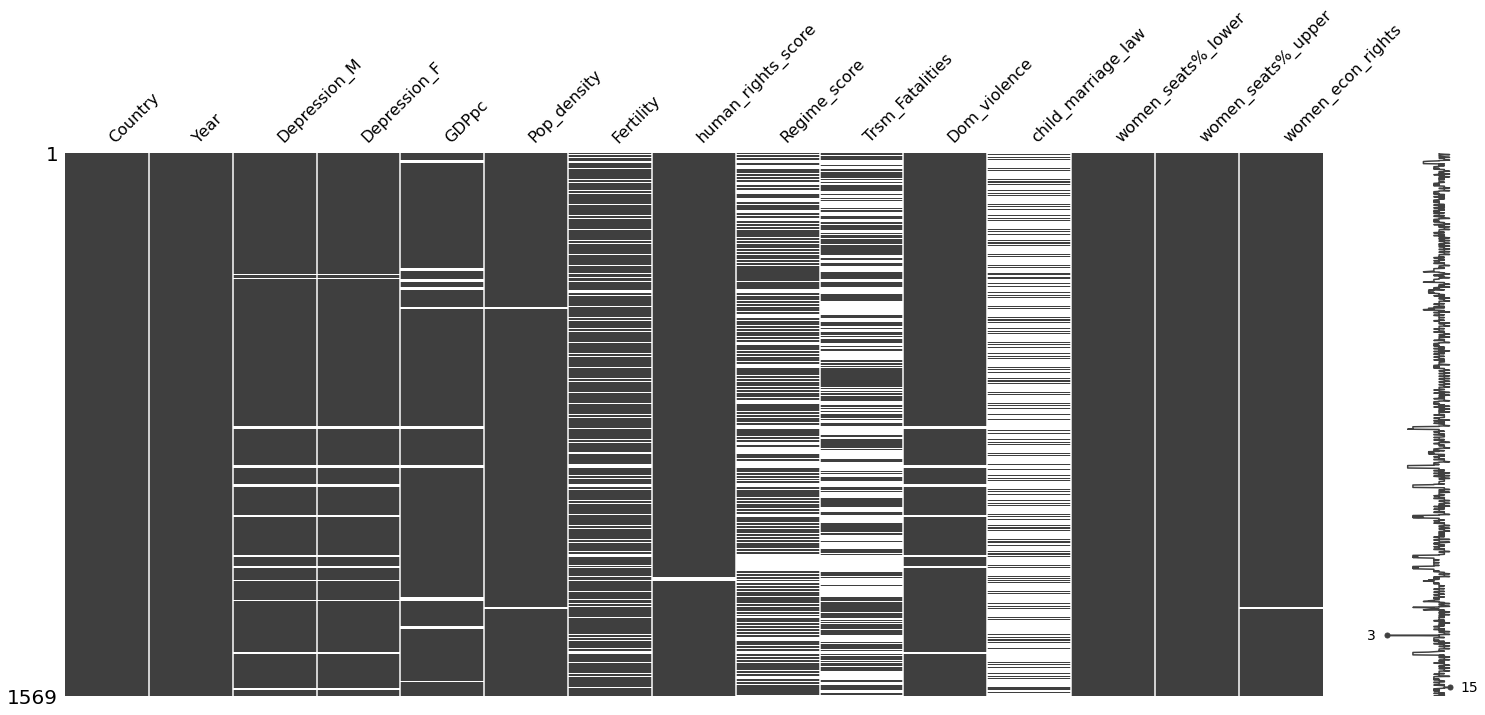

In [6]:
miss.matrix(dat)

In [7]:
#drop the rows where the predicted outcome is 0 (prevalence)
bool_series = pd.isnull(dat["Depression_F"]) #this is our outcome
#drop NA in outcome
dat = dat[~bool_series]
dat

,Country,Year,Depression_M,Depression_F,GDPpc,Pop_density,Fertility,human_rights_score,Regime_score,Trsm_Fatalities,Dom_violence,child_marriage_law,women_seats%_lower,women_seats%_upper,women_econ_rights
0,Afghanistan,2010.0,3.560976,4.688268,1614.255001,44.118443,5.816,-2.005645,NaN,1157.0,43.425,NaN,23.6%,23.5%,0.000000
1,Afghanistan,2011.0,3.559387,4.690351,1660.739856,45.505314,5.595,-2.068197,NaN,1525.0,42.572,NaN,23.6%,23.5%,0.000000
2,Afghanistan,2012.0,3.563693,4.689637,1839.273579,47.019205,5.380,-2.085662,NaN,3521.0,41.758,NaN,23.6%,23.5%,0.000000
3,Afghanistan,2013.0,3.567000,4.691533,1848.700026,48.604123,5.174,-2.224290,NaN,3709.0,41.005,NaN,23.6%,23.5%,0.000000
4,Afghanistan,2014.0,3.567284,4.690456,1838.960244,50.176179,4.981,-2.223042,-1.0,5414.0,40.337,NaN,23.6%,23.5%,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,Zimbabwe,2013.0,2.769193,3.424106,1929.765001,38.915616,3.957,-0.832728,4.0,1.0,21.512,NaN,31.9%,43.8%,0.892857
1565,Zimbabwe,2014.0,2.778101,3.437674,1925.138698,39.838891,3.903,-0.776670,4.0,0.0,21.346,NaN,31.9%,43.8%,0.892857
1566,Zimbabwe,2015.0,2.789152,3.455323,1912.280261,40.784415,3.836,-0.850764,4.0,NaN,21.162,0.0,31.9%,43.8%,0.892857
1567,Zimbabwe,2016.0,2.799308,3.479071,1879.628119,41.748383,3.760,-0.883085,NaN,NaN,20.959,NaN,31.9%,43.8%,0.892857


In [8]:
#FILL NA'S

dat['Regime_score'] = dat['Regime_score'].fillna(dat.groupby('Country')['Regime_score'].transform('mean'))
dat['Trsm_Fatalities'] = dat['Trsm_Fatalities'].fillna(0)
dat['child_marriage_law'] = dat['child_marriage_law'].fillna(dat.groupby('Country')['child_marriage_law'].transform('max'))
dat['child_marriage_law'] = dat['child_marriage_law'].fillna(0)

dat['women_seats%_lower'] = dat['women_seats%_lower'].str.strip('%').astype('float')
dat['women_seats%_lower'] = dat['women_seats%_lower'].div(100)
dat['women_seats%_lower']

dat.drop('women_seats%_upper', axis = 1, inplace = True)
dat['Fertility'] = dat['Fertility'].fillna(dat.groupby('Country')['Fertility'].transform('mean'))
dat.dropna(inplace = True)

In [9]:
#drop duplicates (Yemen)
dat.drop_duplicates(inplace = True)

## Analysis 

To answer the first part of my analytical question whether the prevalence of depression is indeed more common than in men, I calculated the statistics summary (which covers mean, median, standard deviation, minimum, maximum and 25th and 75th percentile) and used scatterplots to analyze the big picture of patterns in the prevalence. The scatterplots demonstrate the distribution of the prevalence of depression in women and men, and I created a visualization capturing the pattern in each continent. 

Then to determine the factors contributing to depression among women, before building statistical learning models, I first included a correlation matrix and used a heatmap to visualize the matrix. The correlation matrix and heatmap would help us to determine the most and least correlated factors with the prevalence of depression. The result from the correlation matrix would be a reference to decide which variables would be included in the statistical learning models. 

For statistically learning models, I included a linear regression model, K nearest neighbor, decision tree, bagging regressor, and random forest for predictions, and I used mean squared error and R-square as the criteria to choose the most predictive model since this is a regression problem. 

Linear regression is included because it is a classic and simple model that is easy to interpret the relationships between dependent variable and independent variables. We use OLS to estimate the values of the coefficients, and to interpret it, the more predictive the model is, the smaller the sum of all squared errors (calculated as the sum of squared distance between each data to the regressed fitted line) is. 

K nearest neighbor (KNN) is useful for classification and regression, so I included it in this project for this regression problem. The KNN algorithm works under the assumption that similar things exist in certain proximity, meaning that similar things should be near each other.  KNN is also a simple “model”, as it just calculates the distance between data. In my machine learning process, I chose the 10, 15, 20, 25 and 30 nearest neighbors. 

Then I included decision tree. Decision tree is a top-down approach that binarily splits the predictor step by step and it ultimately stops when a criterion is met. The model fit depends on the tree pruning. As the tree gets deeper, the model fit should be higher; nonetheless, deep trees might result in over-fitting. In this model, I chose a tree depth of 2, 3, 4, and 5 to control the maximum tree depth. Decision tree is also easy to interpret the result, but the model fit can be too low or too high. 

Bagging as a procedure is building separate trees from a large number of subsets of data then averaging the prediction. By repeating the process and replacing with different subsets, it largely reduces the variance so that it generates an aggregate average result. The result might be predictive, but trees are correlated with each other. 

Given the flaws of bagging, random forest was included in this analysis. Similar to the idea of trees in bagging, the random forest approach takes a random sample at each split. I chose 2, 3, and 4 for the maximum tree depth, and 500, 600, 800 for the number of estimators. 

In [10]:
dat['FminusM'] = dat.Depression_F - dat.Depression_M #difference between genders
dat.FminusM.describe().round(3)   #seems like female prevalance rate > male prevalence

count    1243.000
mean        1.335
std         0.511
min         0.323
25%         0.971
50%         1.220
75%         1.629
max         2.990
Name: FminusM, dtype: float64

In [11]:
dat.filter(['Depression_F', 'Depression_M', 'FminusM']).aggregate('describe')

,Depression_F,Depression_M,FminusM
count,1243.000000,1243.000000,1243.000000
mean,4.155122,2.820341,1.334781
std,0.807758,0.538383,0.510553
min,2.348094,1.645396,0.323018
25%,3.571690,2.389517,0.971017
50%,4.210536,2.849249,1.219513
75%,4.625780,3.143257,1.629040
max,6.679122,4.771281,2.989724


In [12]:
dat.query("Depression_F == Depression_F.max() or Depression_F == Depression_F.min() ")


,Country,Year,Depression_M,Depression_F,GDPpc,Pop_density,Fertility,human_rights_score,Regime_score,Trsm_Fatalities,Dom_violence,child_marriage_law,women_seats%_lower,women_econ_rights,FminusM
294,Colombia,2016.0,2.024180,2.348094,13135.009899,43.851662,1.853,-0.942923,7.0,52.0,14.871,1.0,0.187,1.225806,0.323915
926,Morocco,2010.0,4.659932,6.679122,6443.253613,72.618505,2.578,-0.226685,-6.0,0.0,19.083,0.0,0.205,0.967742,2.019190


In [13]:
corr_mat = dat.corr().loc[['FminusM','Depression_F'],
                ['GDPpc','Pop_density', 'human_rights_score', 'Regime_score', 'Trsm_Fatalities',
                'Dom_violence', 'child_marriage_law', 'women_seats%_lower','women_econ_rights','Fertility']]

corr_mat.T

,FminusM,Depression_F
GDPpc,0.303126,0.212223
Pop_density,0.077660,0.028979
human_rights_score,0.241429,0.092220
Regime_score,0.167287,-0.026173
Trsm_Fatalities,0.064248,0.090675
Dom_violence,-0.155510,0.173869
child_marriage_law,0.044058,-0.147747
women_seats%_lower,0.131021,0.074732
women_econ_rights,0.320102,0.110304
Fertility,-0.089556,0.121892


In [14]:
#add continent to the table for visualization 

url = "http://statisticstimes.com/geography/countries-by-continents.php"
raw = requests.get(url)

tables = pd.read_html(raw.text)

continent = tables[2][['Country or Area','Continent']]
continent.columns = ['Country','Continent']
continent.Country = coco.convert(list(continent.Country), to = "name_short")
dat = dat.merge(continent, how = 'left', on = 'Country')


Sark not found in regex


In [15]:
avg = dat.filter(['Continent','Depression_F', 'Depression_M', 'FminusM']).groupby(['Continent']).aggregate('mean').reset_index()

In [16]:
avg

,Continent,Depression_F,Depression_M,FminusM
0,Africa,4.399048,3.143769,1.255279
1,Asia,3.977954,2.715450,1.262504
2,Europe,4.241145,2.673438,1.567708
3,North America,3.729133,2.507923,1.221210
4,Oceania,4.281857,3.009361,1.272496
5,South America,3.945923,2.567618,1.378304


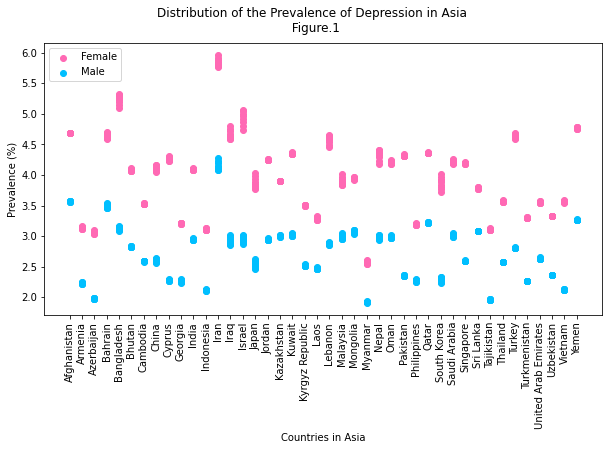

In [18]:
fig = plt.figure(figsize = (10,5))
fig.suptitle("Distribution of the Prevalence of Depression in Asia \n Figure.1")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','Depression_F', data = dat.query("Continent == 'Asia'"), color = 'hotpink', label = 'Female')
plt.scatter('Country','Depression_M', data = dat.query("Continent == 'Asia'"), color = 'deepskyblue', label = 'Male')
plt.xlabel("Countries in Asia")
plt.ylabel("Prevalence (%)")
plt.xticks(rotation='vertical', size = 10)
plt.legend(loc = 'upper left')
plt.show()

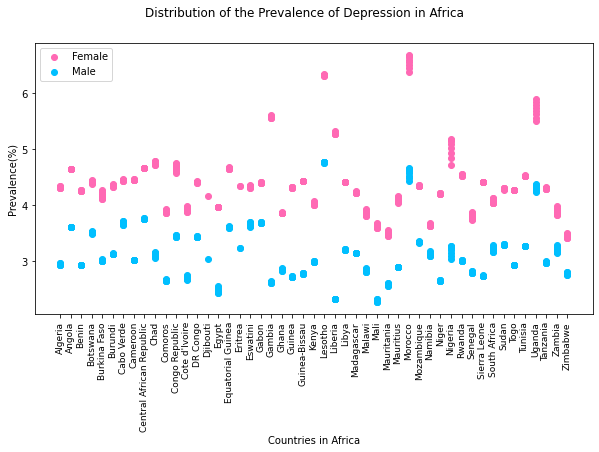

In [19]:
fig = plt.figure(figsize = (10,5))
fig.suptitle("Distribution of the Prevalence of Depression in Africa \n Figure.2")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','Depression_F', data = dat.query("Continent == 'Africa'"), color = 'hotpink', label = 'Female')
plt.scatter('Country','Depression_M', data = dat.query("Continent == 'Africa'"), color = 'deepskyblue', label = 'Male')
plt.xlabel("Countries in Africa")
plt.ylabel("Prevalence(%)")
plt.xticks(rotation= 90, size = 9)
plt.legend(loc = 'upper left')
plt.show()

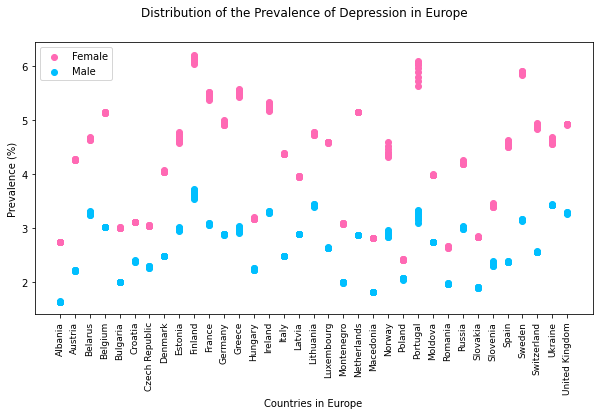

In [20]:
fig = plt.figure(figsize = (10,5))
fig.suptitle("Distribution of the Prevalence of Depression in Europe \n Figure.3")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','Depression_F', data = dat.query("Continent == 'Europe'"), color = 'hotpink', label = 'Female')
plt.scatter('Country','Depression_M', data = dat.query("Continent == 'Europe'"), color = 'deepskyblue', label = 'Male')
plt.xlabel("Countries in Europe")
plt.ylabel("Prevalence (%)")
plt.xticks(rotation= 90, size = 9)
plt.legend(loc = 'upper left')
plt.show()

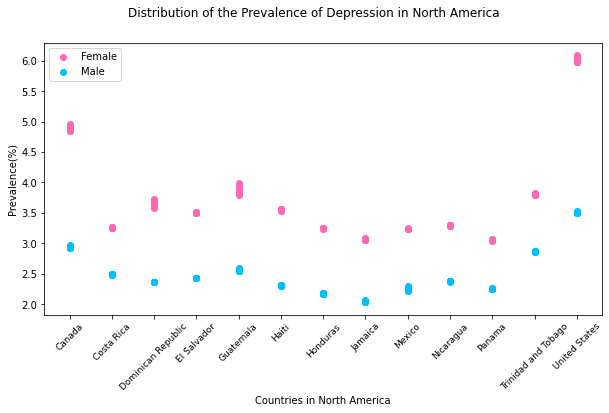

In [21]:
fig = plt.figure(figsize = (10,5))
fig.suptitle("Distribution of the Prevalence of Depression in North America \nFigure.4")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','Depression_F', data = dat.query("Continent == 'North America'"), color = 'hotpink', label = 'Female')
plt.scatter('Country','Depression_M', data = dat.query("Continent == 'North America'"), color = 'deepskyblue', label = 'Male')
plt.xlabel("Countries in North America")
plt.ylabel("Prevalence(%)")
plt.xticks(rotation = 45, size = 9)
plt.legend(loc = 'upper left')
plt.show()

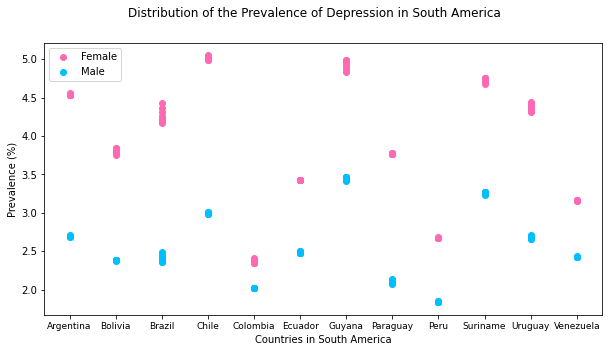

In [22]:
fig = plt.figure(figsize = (10,5))
fig.suptitle("Distribution of the Prevalence of Depression in South America \nFigure.5")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','Depression_F', data = dat.query("Continent == 'South America'"), color = 'hotpink', label = 'Female')
plt.scatter('Country','Depression_M', data = dat.query("Continent == 'South America'"), color = 'deepskyblue', label = 'Male')
plt.xlabel("Countries in South America")
plt.ylabel("Prevalence (%)")
plt.xticks(size = 9)
plt.legend(loc = 'upper left')
plt.show()

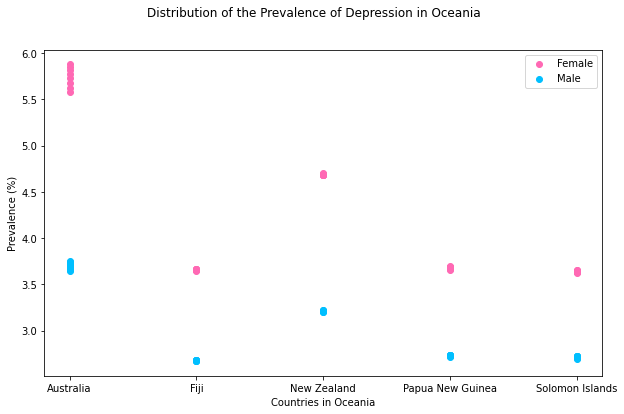

In [23]:
fig = plt.figure(figsize = (10,6))
fig.suptitle("Distribution of the Prevalence of Depression in Oceania \nFigure.5")
#clrs = ['green' if (x <= 0) else 'red' for x in dat.FminusM ]
plt.scatter('Country','Depression_F', data = dat.query("Continent == 'Oceania'"), color = 'hotpink', label = 'Female')
plt.scatter('Country','Depression_M', data = dat.query("Continent == 'Oceania'"), color = 'deepskyblue', label = 'Male')
plt.xlabel("Countries in Oceania")
plt.ylabel("Prevalence (%)")
plt.xticks(size = 10)
plt.legend(loc = 'upper right')
plt.show()

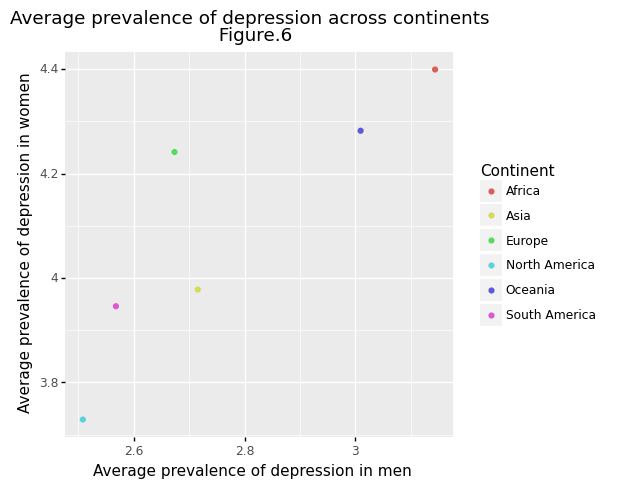

<ggplot: (-9223371942041097244)>

In [58]:
(ggplot(avg,aes(x = 'Depression_M', y = 'Depression_F', color = "Continent"))+
        geom_point() +
        labs(x = "Average prevalence of depression in men", y = 'Average prevalence of depression in women',
             title = 'Average prevalence of depression across continents \n Figure.6')+
        theme(figure_size = (5,5)))

Text(0.5, 1.0, 'Correlation Matrix')

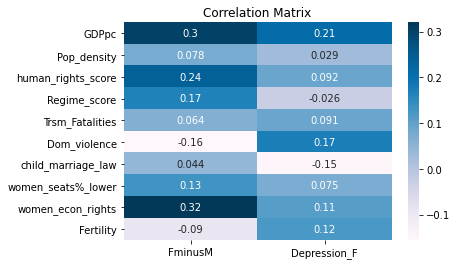

In [24]:
ax = plt.axes()
sns.heatmap(corr_mat.T, annot = True, cmap = 'PuBu')
ax.set_title('Correlation Matrix \nFigure.7')

In [25]:
y = dat[['Depression_F']]
x = dat.drop(columns = ['FminusM','Depression_F','Depression_M','Pop_density','Regime_score','women_seats%_lower','Country','Year','Continent'])

train_x, test_x, train_y, test_y = train_test_split(x,y,test_size = .25,random_state=321)



In [26]:
x.columns

Index(['GDPpc', 'Fertility', 'human_rights_score', 'Trsm_Fatalities',
       'Dom_violence', 'child_marriage_law', 'women_econ_rights'],
      dtype='object')

In [45]:
fold_generator = KFold(n_splits=5, shuffle=True,random_state=321)

preprocess = ColumnTransformer(transformers=[('num',
            pp.MinMaxScaler(), ['GDPpc', 'Fertility', 'human_rights_score',
       'Trsm_Fatalities', 'Dom_violence', 'child_marriage_law',
       'women_econ_rights'])])

#create our model pipe
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


#Specify the models
search_space = [
    # Linear Model
    {'model' : [LM()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},

    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[2,3,4,5]},

    # The Bagging decision tree model
    {'model': [Bag()]},

    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,3,4],
     'model__n_estimators':[500,600,800]},
]


search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

search.fit(train_x,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=321, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['GDPpc',
                                                                          'Fertility',
                                                                          'human_rights_score',
                                                                          'Trsm_Fatalities',
                                                                          'Dom_violence',
                                                                          'child_marriage_law',
                                                                          'women_econ_rights'])])),
                                       ('model', None)]),
      

In [46]:
print("Best score: ", search.best_score_, '\nBest model: ', search.best_params_)

Best score:  -0.0578442444988118 
Best model:  {'model': BaggingRegressor()}


In [47]:
best_mod = search.best_estimator_ #use the best model
best_mod

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['GDPpc', 'Fertility',
                                                   'human_rights_score',
                                                   'Trsm_Fatalities',
                                                   'Dom_violence',
                                                   'child_marriage_law',
                                                   'women_econ_rights'])])),
                ('model', BaggingRegressor())])

In [48]:
train_y_p = search.predict(train_x)

In [49]:
m.r2_score(train_y,train_y_p)

0.9875503104355108

In [50]:
m.mean_squared_error(train_y,train_y_p)

0.008360879019520406

In [51]:
pred_y = search.predict(test_x)

In [52]:
m.mean_squared_error(test_y,pred_y)

0.04200670027723655

In [53]:
m.r2_score(test_y,pred_y)

0.9290610999885188

In [54]:
vi = permutation_importance(best_mod,train_x,train_y,n_repeats=10)

In [55]:
vi_dat = pd.DataFrame(dict(variable=train_x.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,women_econ_rights,1.054793,0.016689,1.021415,1.088171
1,Dom_violence,0.745727,0.032685,0.680357,0.811098
2,GDPpc,0.211850,0.013965,0.183920,0.239780
3,human_rights_score,0.180160,0.004305,0.171549,0.188770
4,Fertility,0.170394,0.009506,0.151382,0.189406
5,child_marriage_law,0.031853,0.001662,0.028529,0.035178
6,Trsm_Fatalities,0.014349,0.001242,0.011864,0.016834


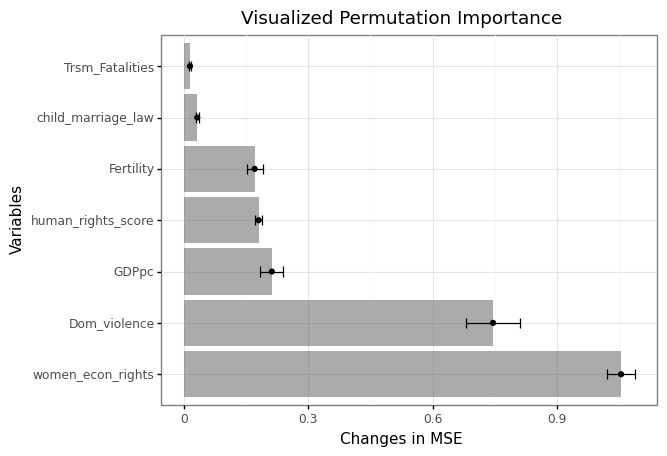

<ggplot: (94813861352)>

In [56]:
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    ggtitle('Visualized Permutation Importance \nFigure.8')+
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Changes in MSE",x="Variables")
)

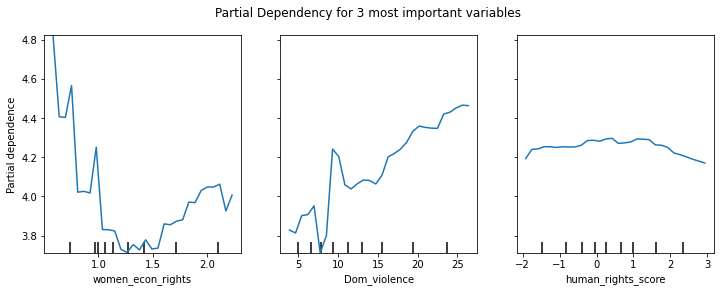

In [57]:
features = ['women_econ_rights','Dom_violence','human_rights_score'] # 3 most important variables

fig, ax = plt.subplots(figsize=(12, 4))
plt.suptitle("Partial Dependency for 3 most important variables \nFigure.9")
display = plot_partial_dependence(
    best_mod, train_x, features,n_cols=3,
    n_jobs=4, grid_resolution=30,ax=ax
)

## Results
To answer the first part of the question, yes, depression is more prevalent in women than in men. Based on the statistics summary, across all 1243 observations that account for 156 countries, the prevalence of depression in women is higher than in men. The mean value of the prevalence of depression among women is 4.155% and the mean value of the prevalence of depression among men is 2.820%; the mean for women is around 47% higher than the mean for men. Out of curiosity, I queried the data and found that the highest prevalence rate of depression among women comes from Morocco in 2010, which is round 6.679%, and the lowest prevalence rate comes from Columbia in 2016, which is around 2.348%. On the other hand, among males, the highest prevalence of depression is about 4.77%, which is just slightly above the average value of prevalence among females, and the lowest is about 1.645%.

I visualized the distribution for each continent and referring to Figure.1 to Figure.5 we can observe a gap between genders in each continent, and by observing the overlapped points, the pattern remains pretty consistent over the years from 2010 to 2017. However, if the average prevalence rate is observed within each continent, the difference is not as significant as the statistics indicate, according to Figure.6.

With the appealing statistics and visualized results, it is reasonable to conclude that the prevalence of depression is more common in women than in men across the world, consistent with the previous research work and my assumptions.

Next, based on the correlation matrix, GDP per capita, rate of domestic violence, and fertility (average births given per woman) are the top three factors leading to the prevalence of depression in women. They have a correlation of 0.21, 0.17, and 0.12, respectively (Figure. 7). Whether the country has a law prohibiting or invalidating child marriage has a correlation of -0.15 with depression, which aligns with the intuition that in countries where girls are able (but are mostly forced) to get married the prevalence of depression is assumed to be higher. On the other hand, population density and the share of women in parliaments and regime score seem to be relatively unimportant in examining factors related to depression, based on a correlation of 0.029, 0.073 and -0.027. I don’t have a legitimate explanation for the results on these three factors, but I did not expect the share of women in parliaments to be very predictive, because I filled the missing values with the most current ones. Therefore, the three least relevant factors are excluded from the statistical learning models.

According to the results from statistical learning models, the most predictive model is the bagging regressor, which generates a mean squared error of 0.0578 for the out-of-sample data and 0.0084 for the in-sample data. With the test data, the mean squared error is 0.042, and the R-squared is 0.929. The R-squared is surprisingly high. However, according to the results from permutation importance, the model does have some highly predictive variables. As visualized in the graph (Figure.8), women’s economic rights, rate of domestic violence, and human rights score are the three most important variables in the prediction model, and the results do not completely agree with the previously estimated correlation matrix. Deaths from terrorist attacks and law regarding child marriage are the least predictive variables. The results regarding the variable importance make sense to me as follows: based on the partial dependency graph (Figure.9), we can tell that there is almost a quadratic relationship between women’s economic rights and the partial dependency, and it seems reasonable since one would expect that the marginal effect of women’s economic rights would be higher when the rights are either very low or very high; the results of domestic violence are very intuitive, as just expected; and the marginal effect of human rights score is relatively even across the range. Also, the high R-squared might be resulted from the relatively steady change over the years since the numeric variables are very close to each other within each country. A solution to the problem would be only including one year of data for each country, but then the sample size would be too small to take useful insights from the results.

## Discussion

I believe I achieved my objective set in the proposal that I am able to answer my analytical question. In my preliminary analysis, my results did not come out as expected, due to a different selection of sample. At first, I chose to use the prevalence of mental health disorders as my outcome; however, that variable is complicated composite of all types of mental health disorders, so it conceals the real patterns regarding the difference between genders. With additional research, I decided to focus on depression instead, because depression is one of the most common mental health disorders. Therefore, I was able to observe a clear pattern between genders and build a predictive statistical learning model. Although I have some doubts regarding the very high result, at the current stage, I have tried the best and I am satisfied with the outcome. One big challenge that could possibly confine the ability to generate a better result is the data: medical experts believe that global statistics on mental health are poorly understood and reported and mental health disorders are underdiagnosed, so there are chances that there exists huge measurement error in the datasets, potentially biasing the results. Additionally, reiterating what I mentioned earlier, I believe due to the country-year nature, data values within each country are too close to each other, so that the R-square is as high as 92.9%. 

If more time is given, I would take a set of actions to expand analysis. First, I would explore more data related to health, such as government expenditure on health, exposure to mental health knowledge, and cost of healthcare, especially for mental health. Unfortunately, data related to health (both physical and mental health) are incomplete and somewhat outdated, so it would take a lot of time working on them; but it might be doable if more time is given. In addition, I would like to expand the dataset with more variables regarding the gender equality issue. Likewise, these data are incomplete and underreported, unless data are retrieved through individual country’s sources. Third, I would look into other types of mental health disorders, such as bipolar and substance use, to determine if the conclusion still stand. And if the analysis covers other types of disorders, then more data ought to be retrieved, for instance, I would like to gather data about alcohol consumption, religion, access to drugs, median income, etc. In conclusion, I would like to explore additional data to conduct a more thorough analysis with more dimensions. 



In [70]:
print("World Count: 2617")

World Count: 2617


## Work Cited

### Articles
Mayo Clinic. (2019). "Depression in women: Understanding the gender gap". Published online at mayoclinic.org. Retrieved from https://www.mayoclinic.org/diseases-conditions/depression/in-depth/depression/art-20047725 

Ritchie, H and Roser M. (2018). "Mental Health". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/mental-health' [Online Resource]

Ritchie, H (2018). "Global mental health: five key insights which emerge from the data". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/mental-health' [Online Resource]



### Data
Cingranelli & Richards. (2014). WOMEN'S ECONOMIC RIGHTS - CIRI_WECON. The Quality of Government Institute. http://qog.pol.gu.se/data, http://www.humanrightsdata.com/

Gapminder(2017). Fertility Rate. GapMinder. https://drive.google.com/drive/folders/1i30LyIcvbLa800Q1ZFrPGlNHIw9ymYGm

Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2017 (GBD 2017) Results. Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2018. http://ghdx.healthdata.org/gbd-results-tool

FEMALE INTIMATE PARTNER VIOLENCE. Institute for Health Metrics and Evaluation (IHME). http://ghdx.healthdata.org/record/ihme-data/gbd-2017-health-related-sdgs-1990-2030

List of Countries by Continent. (2019). Statistics Time. Retrievd from http://statisticstimes.com/geography/countries-by-continents.php 

NUMBER OF TERRORIST INCIDENTS (GDT, 2018). Global Terrorism Database (GTD). University of Maryland. https://www.start.umd.edu/gtd/

POLITICAL REGIME (OWID BASED ON POLITY IV AND WIMMER & MIN). Our World in Data. Retrieved from https://ourworldindata.org/human-rights#:~:text=The%20human%20rights%20scores%20represent,which%20is%20set%20to%20zero. 

Schnakenberg, K. E. & Fariss, C. J. (2014). Dynamic Patterns of Human Rights Practices. Political Science Research and Methods, 2(1), 1–31. doi:10.1017/psrm.2013.15 Fariss, C. J. (2019). Yes, Human Rights Practices Are Improving Over Time. American Political Science Review. Advance online publication. doi: 10.1017/S000305541900025X

"Women in national parliaments". (2019). Inter-Parliamentary Union. Retrieved from http://archive.ipu.org/wmn-e/classif.htm 

World Bank. (2017). Population Density. Food and Agriculture Organization and World Bank population estimates.http://data.worldbank.org/data-catalog/world-development-indicators

World Bank. (2017). GDP Per Capita. World Bank, International Comparison Program database. http://data.worldbank.org/data-catalog/world-development-indicators

World Bank. (2017). LAW PROHIBITS OR INVALIDATES CHILD OR EARLY MARRIAGE (1=YES; 0=NO). World Bank: Women, Business and the Law. http://data.worldbank.org/data-catalog/world-development-indicators 

### Packages
John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55 (publisher link)

Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) https://jmlr.org/papers/v12/pedregosa11a.html

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 0.1038/s41586-020-2649-2. (Publisher link).

Waskom, M. et al., 2017. mwaskom/seaborn: v0.8.1 (September 2017), Zenodo. Available at: https://doi.org/10.5281/zenodo.883859

Wes McKinney. Data Structures for http://conference.scipy.org/proceedings/scipy2010/mckinney.htmlStatistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010) http://conference.scipy.org/proceedings/scipy2010/mckinney.html

Wickham H (2016). ggplot2: Elegant Graphics for Data Analysis. Springer-Verlag New York. ISBN 978-3-319-24277-4, https://ggplot2.tidyverse.org
